In [34]:
import swiftsimio as sw
import velociraptor as vr
import h5py
import unyt
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

In [42]:
class NeuralNetwork():
    def __init__(self, lr):
        self.model = None
        self.optimizer = None
        self.lr = lr
        self.batch_size = 64
        self.epochs = 10
    

    def set_linear_model(self, nr_inputs):
        self.model = torch.nn.Sequential(
            torch.nn.Linear(nr_inputs, 100),
            torch.nn.Linear(100, 1)
        )
    
    def set_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters())
    

    def train(self, data):
        for epoch in range(self.epochs):
            epoch_start = time.time()
            nr_batches = int(len(data.trainy)/self.batch_size) - 1
            for batch in range(nr_batches):
                batch_start = batch*self.batch_size
                batch_stop = (batch+1)*self.batch_size
                y_pred = self.model(torch.Tensor(data.trainx[batch_start:batch_stop]))
                target = torch.Tensor(data.trainy[batch_start:batch_stop])
                loss = (y_pred - target).square().sum()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(f"Epoch: {epoch}, done in {time.time() - epoch_start:.2f} seconds")

    def test(self, data):
        prediction = self.model(torch.Tensor(data.testx[:64]))
        print(prediction[:10])
        print(data.testy[:10])

In [43]:
class Data():
    def __init__(self, soap_path, sw_path = "", selection_type="SO/500_crit/"):
        self.soap_file = h5py.File(f"{soap_path}", "r")
        self.selection_type = selection_type
        self.sw_path = sw_path

        self.properties = []
        self.set_nr_halos()
    
    def add_soap_property(self, path):
        self.properties.append(path)


    def make_soap_dataset(self, target_property="GasMass", use_log=True):
        data_x = np.zeros((self.nr_halos, len(self.properties)))
        for i in range(len(self.properties)):
            data_x[:,i] = self.soap_file[f"{self.selection_type}{self.properties[i]}"]
        
        data_y = np.array(self.soap_file[f"{self.selection_type}{target_property}"])

        nonzero_target = (data_y != 0)
        nonzero_data = (np.sum(data_x == 0, axis=1) == 0)
        nonzero = nonzero_target * nonzero_data

        data_x = data_x[nonzero]
        data_y = data_y[nonzero]
        shuffled_indices = np.arange(len(data_x))
        np.random.shuffle(shuffled_indices)

        if use_log:
            data_x = np.log10(data_x)
            data_y = np.log10(data_y)

        test_len = int(0.2*len(data_x))
        self.trainx = data_x[test_len:]
        self.trainy = data_y[test_len:]
        self.testx = data_x[:test_len]
        self.testy = data_y[:test_len]
        


    def set_nr_halos(self):
        self.nr_halos = self.soap_file[f"{self.selection_type}/CentreOfMass"].shape[0]

In [44]:
data = Data("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0077.hdf5")
data.add_soap_property("SORadius")
data.add_soap_property("StarFormationRate")
data.add_soap_property("GasTemperature")
data.make_soap_dataset("GasMass")

In [45]:
model = NeuralNetwork(0.001)
model.set_linear_model(len(data.properties))
model.set_optimizer()

model.train(data)
model.test(data)

Epoch: 0, done in 4.58 seconds
Epoch: 1, done in 4.35 seconds
Epoch: 2, done in 3.97 seconds
Epoch: 3, done in 4.52 seconds
Epoch: 4, done in 3.98 seconds
Epoch: 5, done in 4.19 seconds
Epoch: 6, done in 4.62 seconds
Epoch: 7, done in 4.34 seconds
Epoch: 8, done in 3.89 seconds
Epoch: 9, done in 4.47 seconds
tensor([[12.2736],
        [12.2865],
        [12.3272],
        [12.1962],
        [12.0197],
        [12.2346],
        [12.1814],
        [11.9981],
        [12.0926],
        [12.0330]], grad_fn=<SliceBackward0>)
[13.695617  13.730842  13.6479845 13.499366  13.55475   13.592955
 13.481519  13.324218  13.378035  13.27956  ]


In [ ]:
halos = vr.load("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0077.hdf5")
target = halos.root.so.v500_crit.gasmass
datapoints = np.zeros((len(target), 6))
datapoints[:,0] = halos.root.so.v500_crit.xrayluminosity[:,0]
datapoints[:,1] = halos.root.so.v500_crit.xrayluminosity[:,1]
datapoints[:,2] = halos.root.so.v500_crit.xrayluminosity[:,2]
datapoints[:,3] = halos.root.so.v500_crit.soradius
datapoints[:,4] = halos.root.so.v500_crit.starformationrate
datapoints[:,5] = halos.root.so.v500_crit.gastemperature


nonzero_target = (target != 0)
nonzero_datapoints = np.sum(datapoints==0, axis=1) == 0
nonzero = nonzero_target * nonzero_datapoints

target = target[nonzero]
datapoints = datapoints[nonzero]
print(target.shape)
print(datapoints.shape)

(246276,)
(246276, 6)


In [ ]:

target = torch.tensor(target, dtype=torch.float32).log10()
datapoints = torch.tensor(datapoints, dtype=torch.float32).log10()

In [ ]:
print(target)
print(datapoints)

tensor([13.6956, 13.7308, 13.6480,  ..., 10.4212, 10.6865, 10.6085])
tensor([[ 8.6196,  8.5411,  8.4599,  3.0608,  8.0414,  7.6634],
        [ 8.7194,  8.7335,  8.5588,  3.0796,  7.9918,  7.6956],
        [ 8.4475,  8.3345,  8.2899,  3.0534,  8.2660,  7.6585],
        ...,
        [ 2.4684, -9.8334,  1.5323,  2.0433,  5.9140,  4.9621],
        [ 3.7946, -0.6459,  3.1396,  2.1103,  6.5626,  5.5347],
        [ 3.1931, -4.0453,  2.1682,  2.0579,  6.9165,  5.1006]])


In [ ]:


for t in range(9000):
    random_batch_indices = np.arange(len(datapoints))
    np.random.shuffle(random_batch_indices)

    random_batch = datapoints[random_batch_indices[:100]]
    y_pred = model(random_batch)
    loss = (y_pred - target[random_batch_indices[:100]]).square().sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print(t)


print(model(datapoints[:5]))
print(target[:5])

tensor([[11.4549],
        [11.4586],
        [11.4753],
        [11.4444],
        [11.3992]], grad_fn=<AddmmBackward0>)
tensor([13.6956, 13.7308, 13.6480, 13.4994, 13.5548])


In [ ]:
prediction = model(datapoints)
print(prediction[0])

tensor([11.4549], grad_fn=<SelectBackward0>)


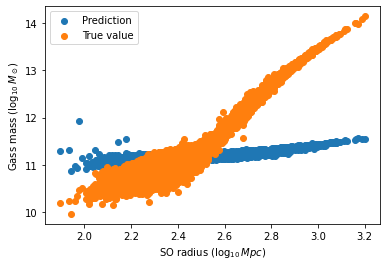

In [ ]:
nr_points = 10000
plt.scatter(datapoints[:nr_points, 3], prediction[:nr_points].detach(), label="Prediction")
plt.scatter(datapoints[:nr_points, 3], target[:nr_points].detach(), label="True value")
plt.xlabel("SO radius ($\log_{10}Mpc$)")
plt.ylabel("Gass mass ($\log_{10}M_\odot$)")
plt.legend()
plt.show()

tensor(3.0608)
